#### 隨機產生args....!!!

In [1]:
import os 
from time import time
from random import uniform

import pandas as pd 
import numpy  as np 
import torch
import matplotlib.pyplot as plt 

from tqdm import tqdm

from utils import load_mch
from utils.mch import MCHHandler

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
wl = [i for i in range(660, 921, 10)]
%matplotlib inline

In [151]:
x_range = {
    "idx": None,
    "skin_b": (0.0012, 0.0041),
    "skin_s": (0.985, 1.0),
    "skin_w": (0.166, 0.261),
    "skin_f": (0.187, 0.277),
    "skin_m": (0.0087, 0.0165),

    "fat_f": (0.5, 1),

    "muscle_b": (0.005, 0.050),
    "muscle_s": (0.5, 0.9),
    "muscle_w": (0.5, 0.9),

    "ijv_s": (0.0, 1.0),

    "cca_s": (0.0, 1.0),
}
x_range = {
    "idx": None,
    "sb": (0, 0.1),
    "ss": (0, 1.0),
    "sw": (0, 0.5),
    "sf": (0, 0.5),
    "sm": (0, 1.0),

    "ff": (1, 1),

    "mb": (0.005, 0.1),
    "ms": (0.0, 0.2),
    "mw": (0.0, 0.3),

    "is": (0.4, 0.8),

    "cs": (0.5, 1.0),
}

In [152]:
def get_args(xrange, num=50000):
    args = []
    for i in range(num):
        sb = uniform(x_range["sb"][0], x_range["sb"][1])
        ss = uniform(x_range["ss"][0], x_range["ss"][1])
        sw = uniform(x_range["sw"][0], max(x_range["sw"][0], min(x_range["sw"][1], 1-sb)))
        sf = uniform(x_range["sf"][0], max(x_range["sf"][0], min(x_range["sf"][1], 1-sb-sw)))
        sm = 1-sb-sw-sf
        mb = uniform(x_range["mb"][0], x_range["mb"][1])
        ms = uniform(x_range["ms"][0], x_range["ms"][1])
        mw = uniform(x_range["mw"][0], max(x_range["mw"][0], min(x_range["mw"][1], 1-mb)))
        mc = 1 - mb - mw
        is_ = uniform(x_range["is"][0], x_range["is"][1])
        cs = uniform(x_range["cs"][0], x_range["cs"][1])
        arg = {
            "skin":{
                "blood_volume_fraction": sb,
                "ScvO2": ss,
                "water_volume": sw,
                "fat_volume": sf,
                "melanin_volume": sm,
                "collagen_colume": 0
            },

            "fat":{
                "blood_volume_fraction": 0,
                "ScvO2": 0,
                "water_volume": 0,
                "fat_volume": 1,
                "melanin_volume": 0,
                "collagen_colume": 0
            },

            "muscle":{
                "blood_volume_fraction": mb,
                "ScvO2": ms,
                "water_volume": mw,
                "fat_volume": 0,
                "melanin_volume": 0,
                "collagen_colume": mc
            },
            "ijv":{
                "blood_volume_fraction": 1,
                "ScvO2": is_,
                "water_volume": 0,
                "fat_volume": 0,
                "melanin_volume": 0,
                "collagen_colume": 0
            },
            "cca":{
                "blood_volume_fraction": 1,
                "ScvO2": cs,
                "water_volume": 0,
                "fat_volume": 0,
                "melanin_volume": 0,
                "collagen_colume": 0
            },
        }
        args += [arg]
    
    return args

args = get_args(x_range)

#### 跑WMC!!

In [4]:
idx = "20190507"
idx = os.path.join("configs", "live", idx)
max_no_prism = idx + "_max" + "_no_prism" + ".json"
max_prism = idx + "_max" + ".json"
min_no_prism = idx + "_min" + "_no_prism" + ".json"
min_prism = idx + "_min" + ".json"

In [5]:
mch = MCHHandler()

In [153]:
mch.load_config(max_no_prism)
s_max, r_max = mch.run_wmc(args)

In [154]:
mch.load_config(min_no_prism)
s_min, r_min = mch.run_wmc(args)

In [142]:
mch.load_config(max_prism)
s_max_prism, r_max_prism = mch.run_wmc(args, prism=True)

In [143]:
mch.load_config(min_prism)
s_min_prism, r_min_prism = mch.run_wmc(args, prism=True)

#### 計時

In [111]:
gpu_time = []

mch.load_config(max_no_prism)
for i in range(1, 10000, 1000):
    s = time()
    _, _ = mch.run_wmc(args[:i])
    e = time()
    gpu_time += [e-s]
print("cuda time: ", e-s)

cuda time:  34.697102069854736


In [112]:
cpu_time = []

mch.load_config(min_no_prism)
for i in range(1, 10000, 1000):
    s = time()
    _, _ = mch.run_wmc(args[:i], device="cpu")
    e = time()
    cpu_time += [e-s]
print("cpu time: ", e-s)

KeyboardInterrupt: 

In [ ]:
plt.plot([i for i in range(1, 10000, 1000)], cpu_time, label="cpu")
plt.plot([i for i in range(1, 10000, 1000)], gpu_time, label="gpu")
plt.xlabel("ipnut size")
plt.ylabel("time [sec]")
plt.legend()
plt.grid()
plt.show()

#### 各組織路徑長

In [15]:
r_min[0, :, 0]

array([0.04303022, 0.05941279, 0.61234397, 0.04402264, 0.00071521])

#### max/min相比

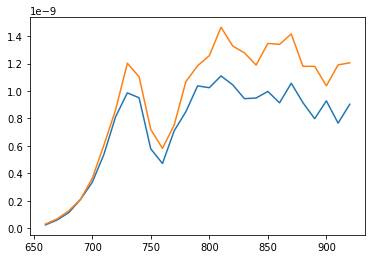

In [73]:
plt.plot(wl, s_max[0, 1, :])
plt.plot(wl, s_min[0, 1, :])

10


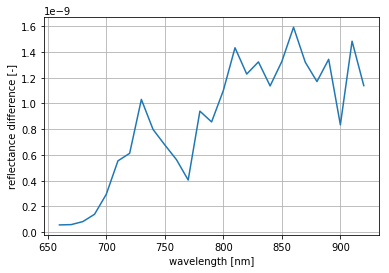

11


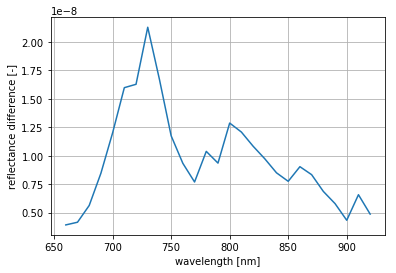

12


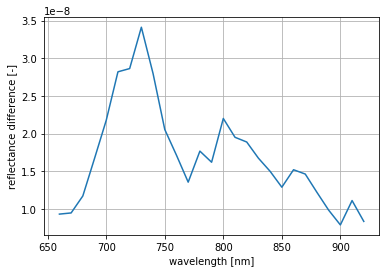

13


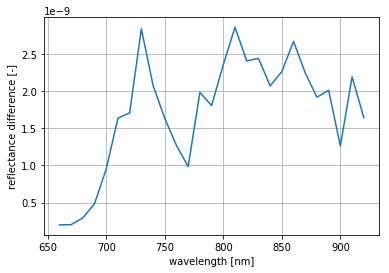

14


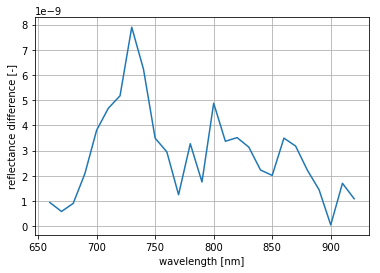

15


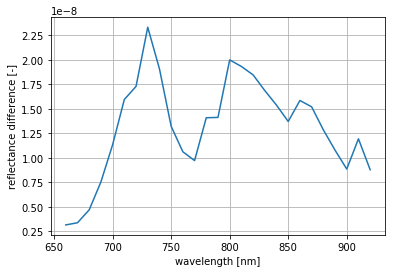

16


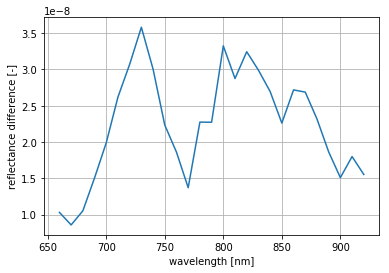

17


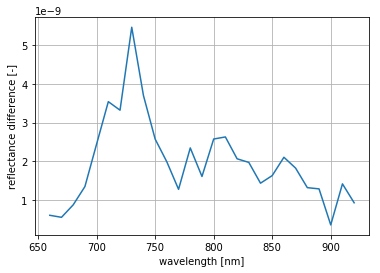

18


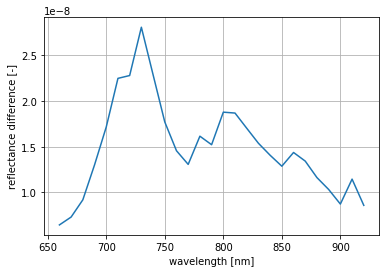

19


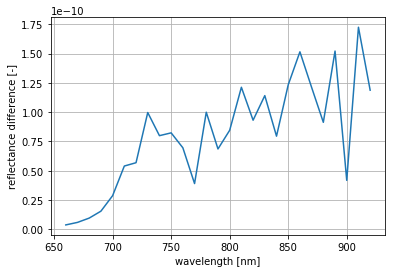

In [77]:
for i in range(10, 20):
    print(i)
    plt.plot(wl, s_min[i, 1, :] - s_max[i, 1, :])
    plt.xlabel("wavelength [nm]")
    plt.ylabel("reflectance difference [-]")
    plt.grid()
    plt.show()

In [76]:
args[18]

{'skin': {'blood_volume_fraction': 0.6573422409108316,
  'ScvO2': 0.9164422353191374,
  'water_volume': 0.18706894400027183,
  'fat_volume': 0.12553608475146605,
  'melanin_volume': 0.030052730337430528,
  'collagen_colume': 0},
 'fat': {'blood_volume_fraction': 0,
  'ScvO2': 0,
  'water_volume': 0,
  'fat_volume': 1,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'muscle': {'blood_volume_fraction': 0.01295883774275447,
  'ScvO2': 0.3251160326046738,
  'water_volume': 0.5687562108427497,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0.41828495141449573},
 'ijv': {'blood_volume_fraction': 1,
  'ScvO2': 0.6721744694735597,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'cca': {'blood_volume_fraction': 1,
  'ScvO2': 0.834630804823658,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0}}

In [82]:
# mch.mch_list[0]
d, head, _ = mch._load_mch(mch.mch_list[0])

In [84]:
d.groupby("detector_idx").mean()

,media_0,media_1,media_2,media_3,media_4,angle
detector_idx,,,,,,
1.0,3.719856,3.018821,41.625578,22.540168,3.597734,-0.677056
2.0,3.976512,3.224929,49.645317,23.179131,4.421984,-0.677229
3.0,4.176792,3.384367,56.619528,23.327934,5.229559,-0.677550


#### 有無凌鏡相比

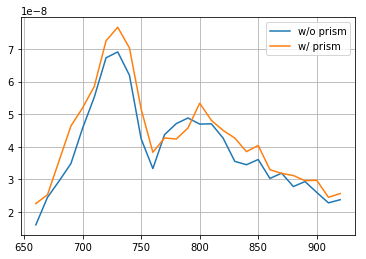

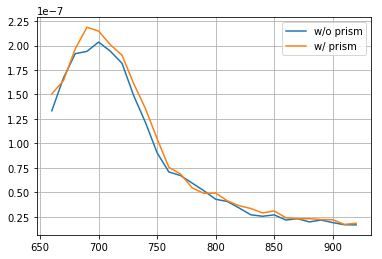

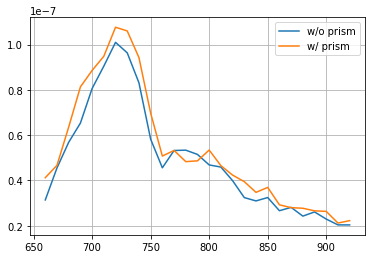

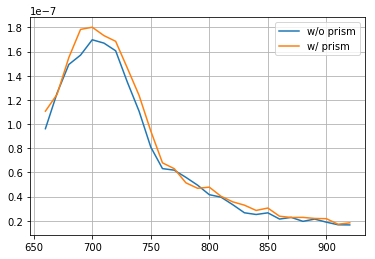

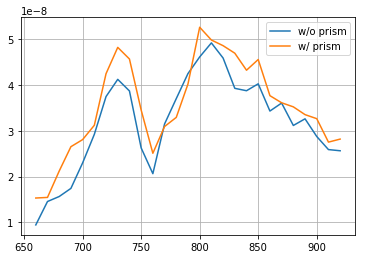

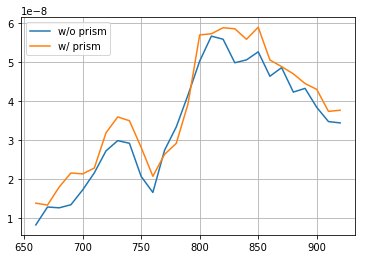

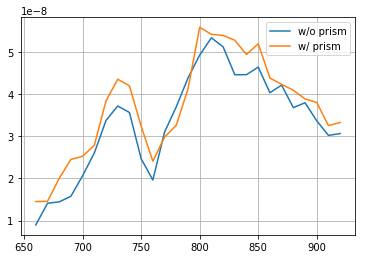

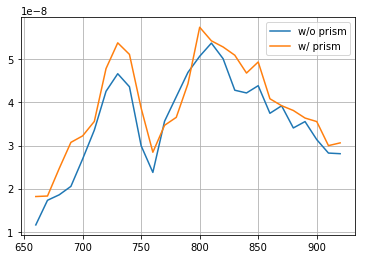

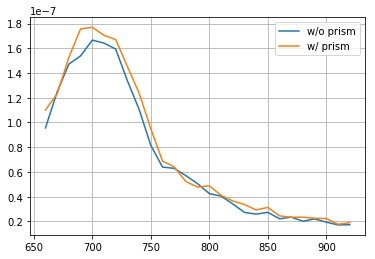

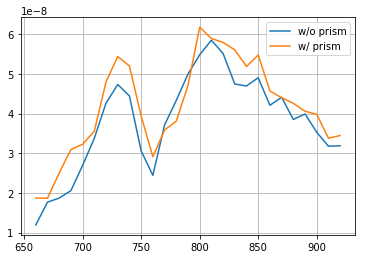

In [36]:
for i in range(10):
    plt.plot(wl, s[i, 1, :], label="w/o prism")
    plt.plot(wl, s2[i, 1, :], label="w/ prism")
    plt.legend()
    plt.grid()
    plt.show()

#### 活體光譜

In [7]:
df = pd.read_csv("data/calibrated/20190507/IJV/20190507_1_1.csv")
df.head(1)

,wavelength,max,min
0,660,9.071441e-10,8.827339e-10


#### 比較波型和強度

#### 未加凌鏡

num: 0 | loss: 2.1826938987936977


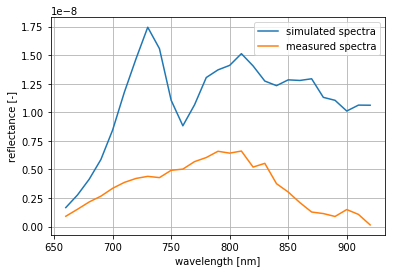

num: 1 | loss: 0.8537877249979118


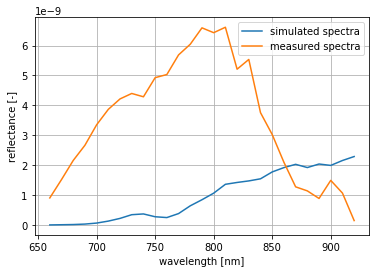

num: 3 | loss: 0.7464068773985342


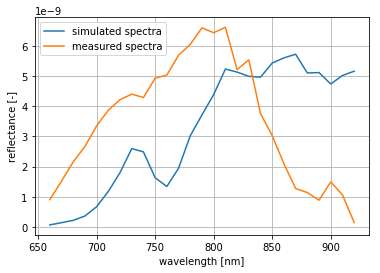

num: 13 | loss: 0.6973548485272928


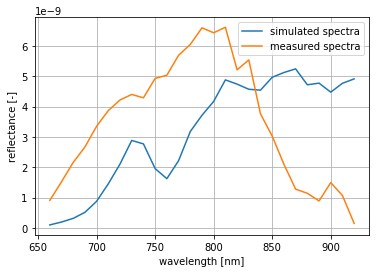

num: 31 | loss: 0.6841106893950493


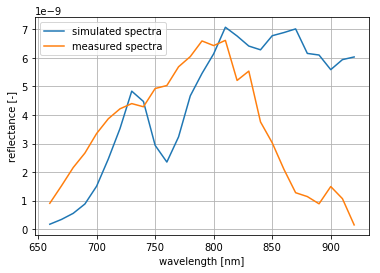

num: 76 | loss: 0.5533598251005645


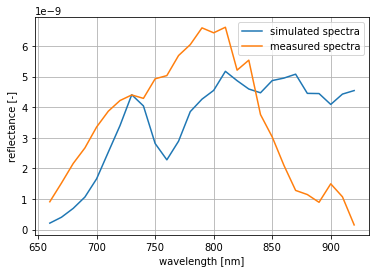

num: 257 | loss: 0.5524971234890437


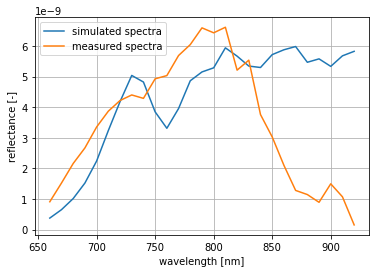

num: 594 | loss: 0.5168556884907791


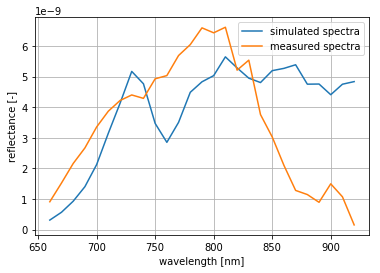

num: 4334 | loss: 0.5060965758983667


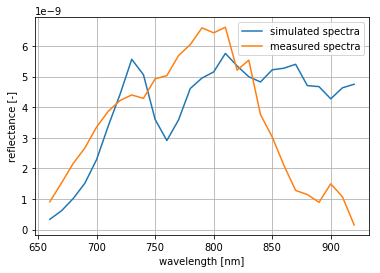

In [155]:
# IJV舒張
loss = 100
for i, s in enumerate(s_min):
    if np.sqrt((s[1,:]-df["max"])**2).mean()/df["max"].mean() < loss:
        loss = np.sqrt((s[1, :] - df["max"])**2).mean()/df["max"].mean()
        print("num: {} | loss: {}".format(i, loss))

        plt.plot(wl, s[1, :], label="simulated spectra") 
        plt.plot(wl, df["max"], label="measured spectra")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

In [144]:
# args[19437]

num: 0 | loss: 1.0483497079086432


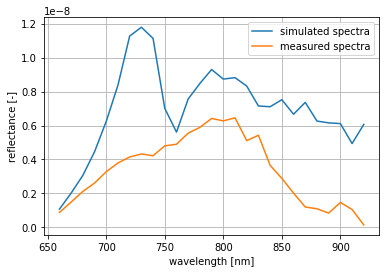

num: 1 | loss: 0.8639321028717714


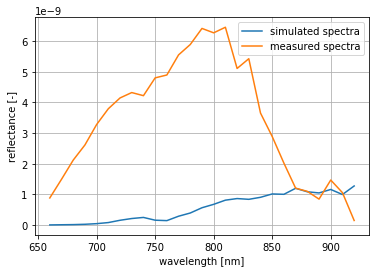

num: 3 | loss: 0.7021324197789897


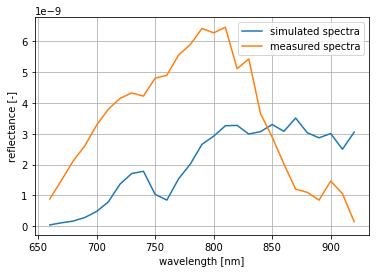

num: 8 | loss: 0.6737942273348527


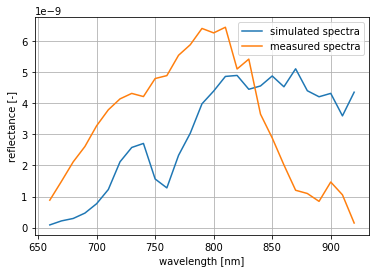

num: 31 | loss: 0.5744563358633663


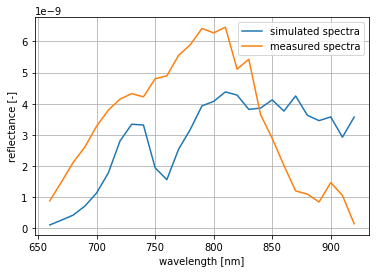

num: 76 | loss: 0.5506762581651258


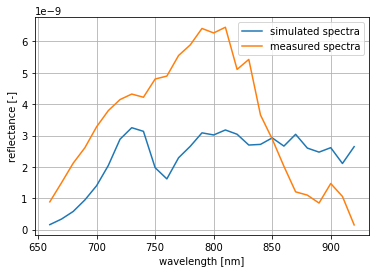

num: 80 | loss: 0.5383660119190736


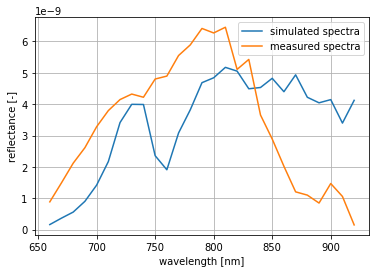

num: 100 | loss: 0.42354437315384313


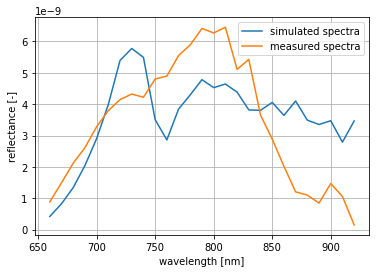

num: 20779 | loss: 0.4213355875325046


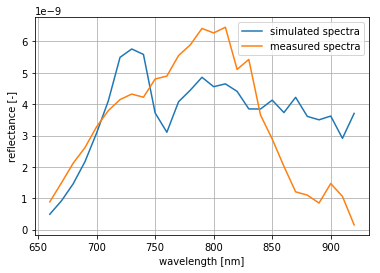

num: 26119 | loss: 0.42046234097435164


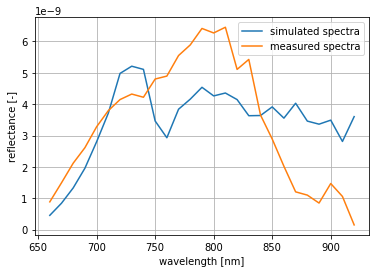

In [156]:
# IJV收縮
loss = 100
for i, s in enumerate(s_max):
    if np.sqrt((s[1,:]-df["min"])**2).mean()/df["min"].mean() < loss:
        
        loss = np.sqrt((s[1, :] - df["min"])**2).mean()/df["min"].mean()
        print("num: {} | loss: {}".format(i, loss))
        
        plt.plot(wl, s[1, :], label="simulated spectra") 
        plt.plot(wl, df["min"], label="measured spectra")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

In [161]:
args[20779], args[26119]
args[100]
args[80]

{'skin': {'blood_volume_fraction': 0.068424634403941,
  'ScvO2': 0.2861021535875746,
  'water_volume': 0.4096036956887599,
  'fat_volume': 0.3308816529631569,
  'melanin_volume': 0.19109001694414224,
  'collagen_colume': 0},
 'fat': {'blood_volume_fraction': 0,
  'ScvO2': 0,
  'water_volume': 0,
  'fat_volume': 1,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'muscle': {'blood_volume_fraction': 0.0778076901536103,
  'ScvO2': 0.029319936529730195,
  'water_volume': 0.24181096411280417,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0.6803813457335854},
 'ijv': {'blood_volume_fraction': 1,
  'ScvO2': 0.6518720747130915,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0},
 'cca': {'blood_volume_fraction': 1,
  'ScvO2': 0.5256174477654757,
  'water_volume': 0,
  'fat_volume': 0,
  'melanin_volume': 0,
  'collagen_colume': 0}}

num: 0 | loss: 0.7827952622796575


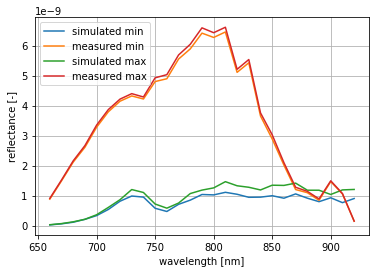

num: 1 | loss: 0.750364279447127


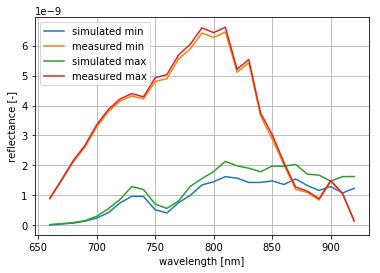

num: 2 | loss: 0.5372284036237347


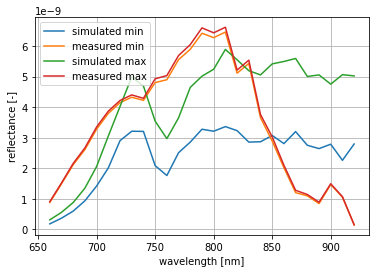

num: 65 | loss: 0.49813501461279586


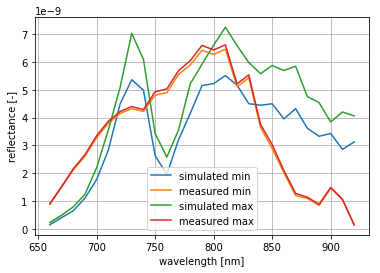

num: 68 | loss: 0.47228202448570955


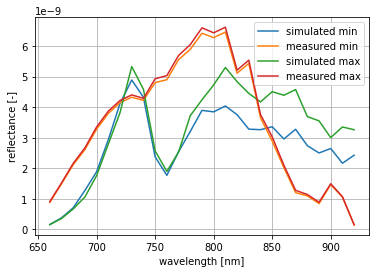

num: 85 | loss: 0.4629630284505286


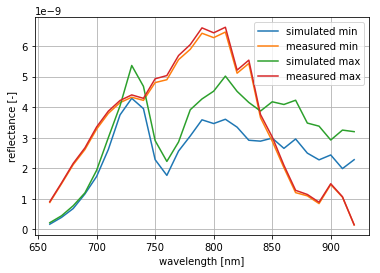

num: 92 | loss: 0.45321458794712577


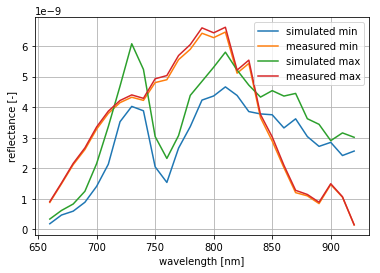

num: 100 | loss: 0.43167718605957756


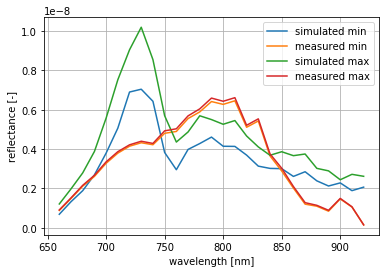

num: 241 | loss: 0.415746747447837


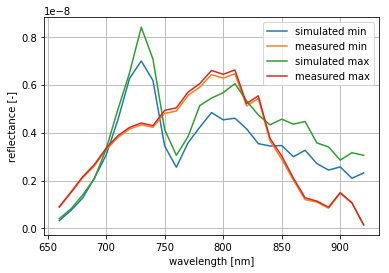

num: 735 | loss: 0.41183924087015256


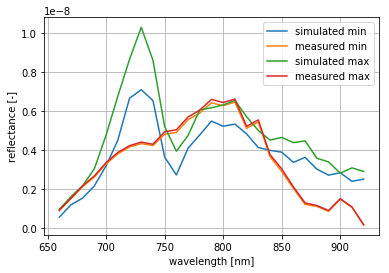

num: 804 | loss: 0.39343421660085187


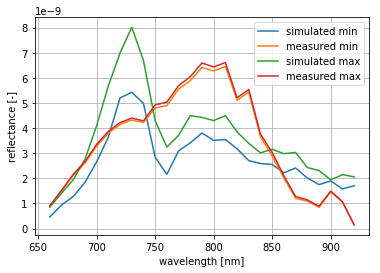

num: 6950 | loss: 0.3919999260775165


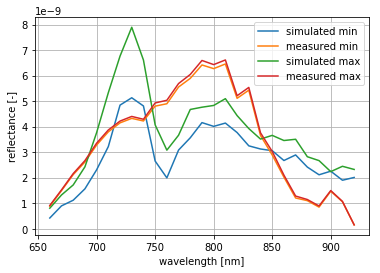

num: 13791 | loss: 0.39152211682113797


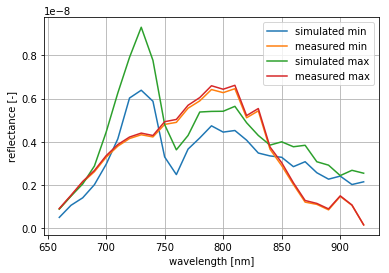

num: 31322 | loss: 0.3911840386797568


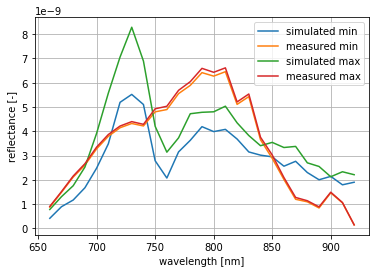

num: 31926 | loss: 0.3904398945606099


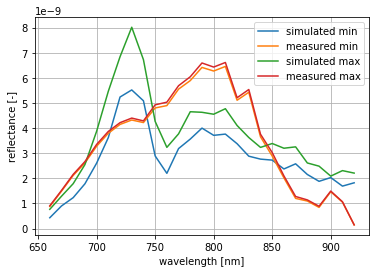

num: 39404 | loss: 0.3895816963585762


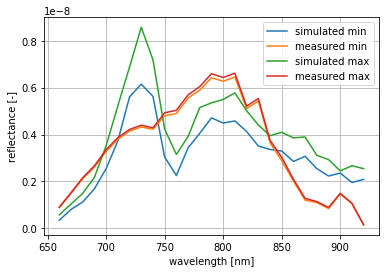

In [116]:
# 一起比較
loss = 100
for i, (smax, smin) in enumerate(zip(s_max, s_min)):
    loss_ = (np.sqrt((smax[1,:]-df["min"])**2).mean()/df["min"].mean() + \
             np.sqrt((smin[1,:]-df["max"])**2).mean()/df["max"].mean()) / 2
    if loss_ < loss:
        
        loss = loss_
        print("num: {} | loss: {}".format(i, loss))
        
        plt.plot(wl, smax[1, :], label="simulated min") 
        plt.plot(wl, df["min"], label="measured min")
        
        plt.plot(wl, smin[1, :], label="simulated max") 
        plt.plot(wl, df["max"], label="measured max")
        
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

In [146]:
# args[39404]

#### 有加凌鏡

num: 0 | loss: 0.9893558448895872


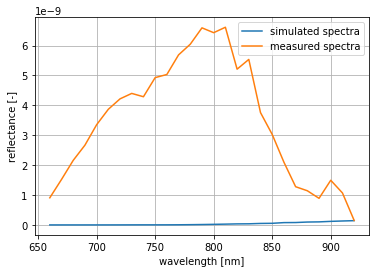

num: 2 | loss: 0.9596255206860296


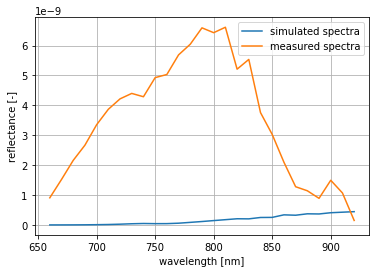

num: 8 | loss: 0.8665083220536155


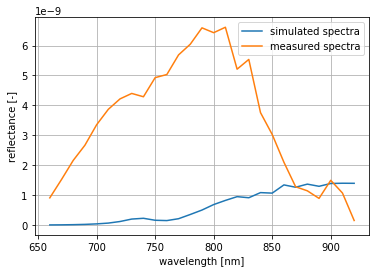

num: 13 | loss: 0.837995181453107


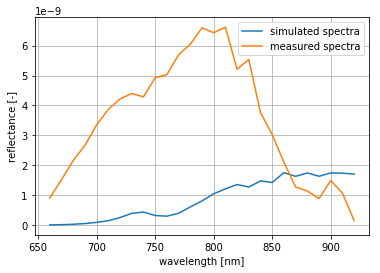

num: 218 | loss: 0.8369951199835334


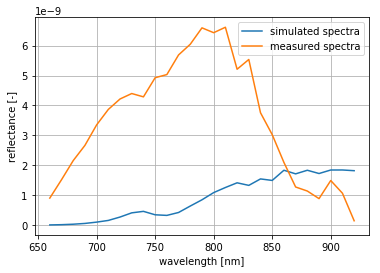

num: 351 | loss: 0.7811693203315359


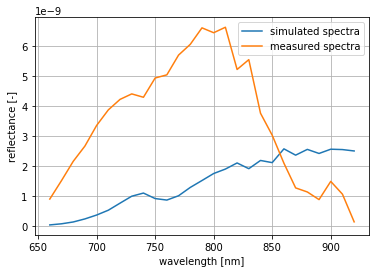

num: 2557 | loss: 0.7767550149243029


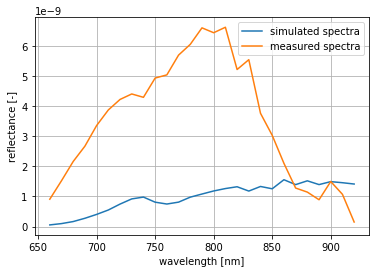

num: 10494 | loss: 0.7732376544398855


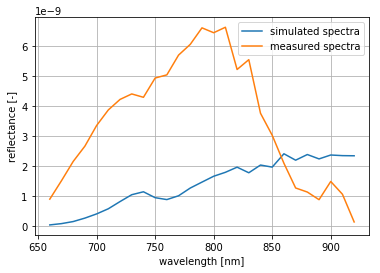

num: 16155 | loss: 0.7641068784792154


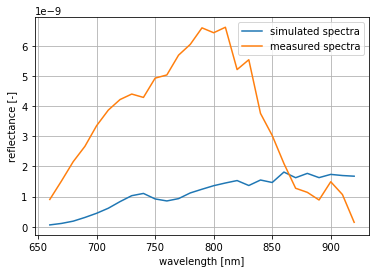

num: 18550 | loss: 0.7514613812518482


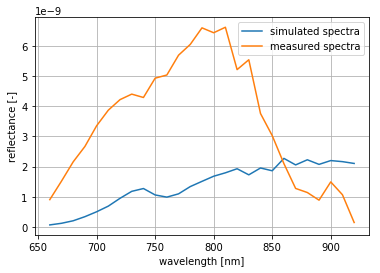

In [149]:
# IJV舒張
loss = 100
for i, s in enumerate(s_min_prism):
    if np.sqrt((s[1,:]-df["max"])**2).mean()/df["max"].mean() < loss:
        loss = np.sqrt((s[1, :] - df["max"])**2).mean()/df["max"].mean()
        print("num: {} | loss: {}".format(i, loss))

        plt.plot(wl, s[1, :], label="simulated spectra") 
        plt.plot(wl, df["max"], label="measured spectra")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

num: 0 | loss: 0.9939139127293962


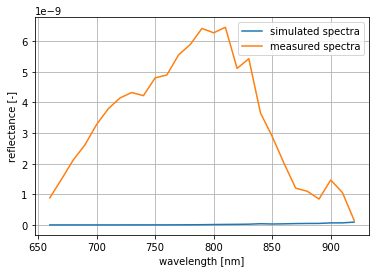

num: 2 | loss: 0.9759320931713279


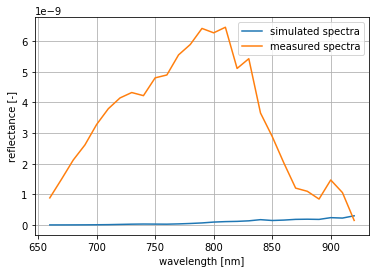

num: 8 | loss: 0.9082599704360947


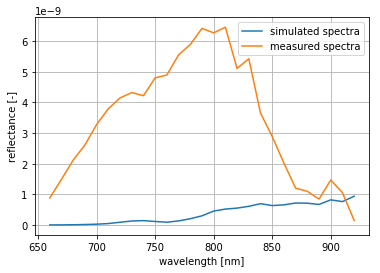

num: 13 | loss: 0.8701730452653126


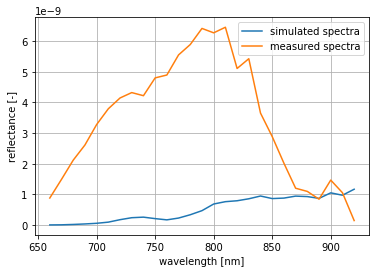

num: 218 | loss: 0.8670310853893023


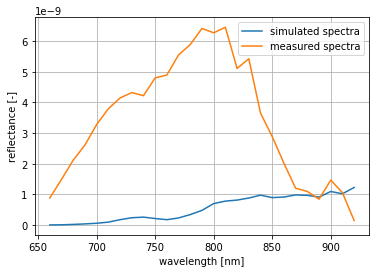

num: 351 | loss: 0.8125803504095062


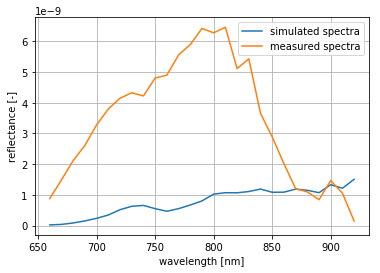

num: 362 | loss: 0.809536527099914


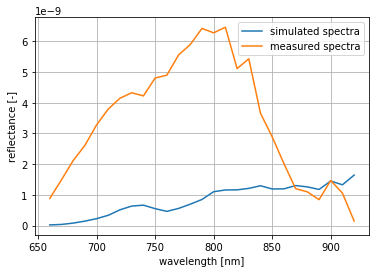

num: 18550 | loss: 0.8033664758136728


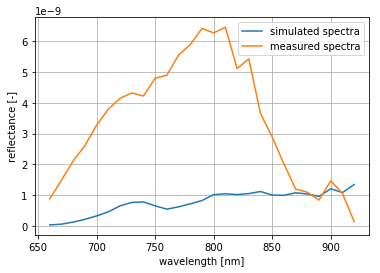

In [150]:
# IJV收縮
loss = 100
for i, s in enumerate(s_max_prism):
    if np.sqrt((s[1,:]-df["min"])**2).mean()/df["min"].mean() < loss:
        
        loss = np.sqrt((s[1, :] - df["min"])**2).mean()/df["min"].mean()
        print("num: {} | loss: {}".format(i, loss))
        
        plt.plot(wl, s[1, :], label="simulated spectra") 
        plt.plot(wl, df["min"], label="measured spectra")
        plt.xlabel("wavelength [nm]")
        plt.ylabel("reflectance [-]")
        plt.legend()
        plt.grid()
        plt.show()

#### 單純比較形狀

0.8045897670420497


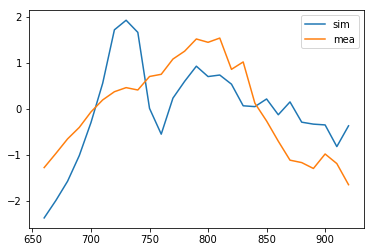

0.7269402879009674


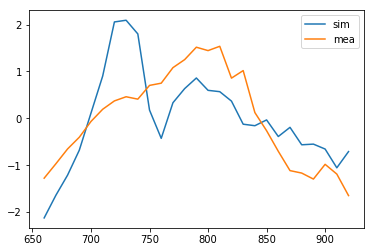

0.6792790214815293


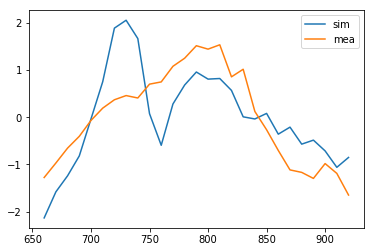

0.6529168258982914


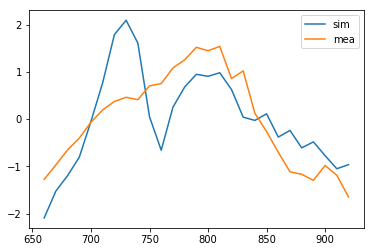

0.591954924117353


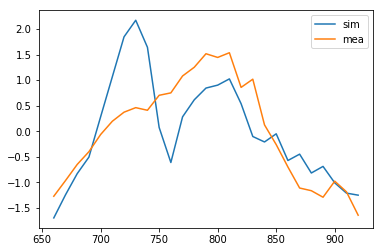

0.5907744113487547


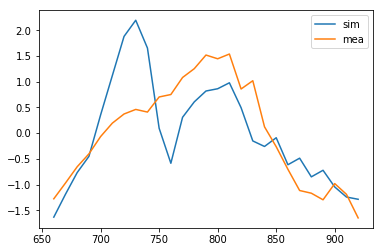

0.5799660998058946


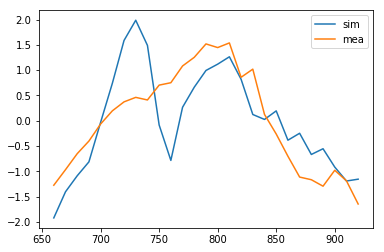

In [157]:
loss = 100
for s in s_max:
    s = (s - np.mean(s, 1, keepdims=True))/np.std(s, 1, keepdims=True)
    m = (df["min"] - df["min"].mean())/df["min"].std()
    if np.sqrt((s[1,:]-m)**2).mean() < loss:
        loss = np.sqrt(((s[1,:]-m))**2).mean()
        print(loss)
        plt.plot(wl, s[1, :], label="sim") 
        plt.plot(wl, m, label="mea")
        plt.legend()
        plt.show()

1.5089376247441695


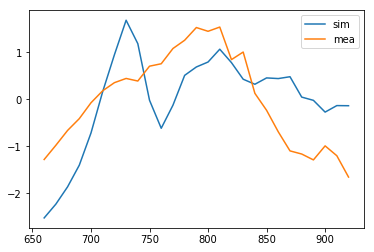

1.1763039576418894


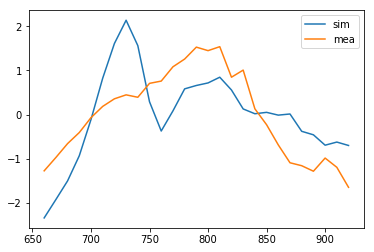

1.105530554630887


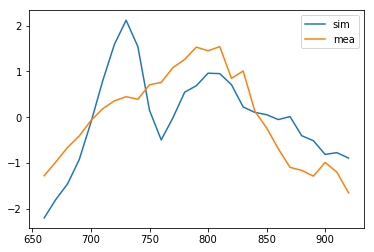

1.1013237426185205


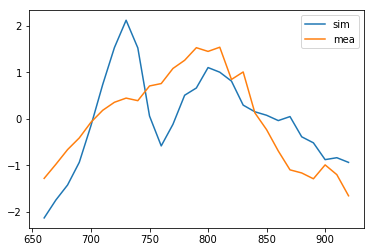

1.0944587794151868


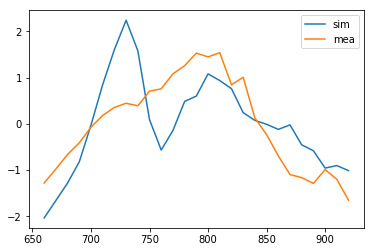

1.0424660563394612


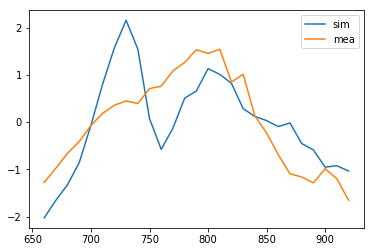

1.0403762848219908


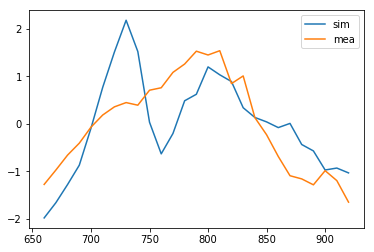

In [158]:
loss = 100
for s in s_min:
    s = (s - np.mean(s, 1, keepdims=True))/np.std(s, 1, keepdims=True)
    m = (df["max"] - df["max"].mean())/df["max"].std()
    if np.sqrt(((s[1,:]-m)/m)**2).mean() < loss:
        loss = np.sqrt(((s[1,:]-m)/m)**2).mean()
        print(loss)
        plt.plot(wl, s[1, :], label="sim") 
        plt.plot(wl, m, label="mea")
        plt.legend()
        plt.show()